## TOC

In [ ]:
from IPython.display import display, Javascript, Markdown

def create_toc():
    display(Markdown('# Table of Contents'))
    
    # JavaScript code to extract headings
    js_code = '''
    var headings = [];
    var cells = Jupyter.notebook.get_cells();
    for (var i = 0; i < cells.length; i++) {
        var cell = cells[i];
        if (cell.cell_type === 'markdown') {
            var lines = cell.get_text().split('\\n');
            for (var j = 0; j < lines.length; j++) {
                var line = lines[j];
                if (line.match(/^#+\\s/)) {
                    var level = line.match(/^#+/)[0].length;
                    var title = line.replace(/^#+\\s/, '').trim();
                    var link = encodeURIComponent(title.replace(/\\s+/g, '-').toLowerCase());
                    headings.push({level: level, title: title, link: link});
                }
            }
        }
    }
    // Pass the headings back to Python
    var py_headings = JSON.stringify(headings);
    var code = "headings = " + py_headings;
    console.log(code);
    IPython.notebook.kernel.execute(code);
    '''
    
    # Execute the JavaScript code
    display(Javascript(js_code))
    
    # Wait for JavaScript to execute and headings to be set
    import time
    time.sleep(1)  # Adjust if necessary
    
    # Generate the markdown table of contents
    try:
        for heading in headings:
            level = heading['level']
            title = heading['title']
            link = heading['link']
            indent = '    ' * (level - 1)
            display(Markdown(f'{indent}- [{title}](#{link})'))
    except NameError:
        print("Could not retrieve headings.")


# Run the function
create_toc()

## LPC (Linear predictive coding) analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter, hamming, freqz
from scipy.signal.windows import hann
import soundfile as sf
from scipy.signal import find_peaks
import IPython.display as ipd

def levinson_durbin(r, order):
    """Levinson-Durbin recursion to solve the Toeplitz system."""
    r = np.asarray(r)
    a = np.zeros(order + 1)
    e = r[0]

    # Ensure e is not zero to avoid division by zero
    if e == 0 or np.isnan(e):
        # Return default coefficients
        a[0] = 1.0
        return a, e

    a[0] = 1.0

    for i in range(1, order + 1):
        if i == 1:
            #reflection coefficient
            kappa = -r[1] / e
            a[1] = kappa
            e *= (1 - kappa ** 2)
        else:
            acc = r[i]
            for j in range(1, i):
                acc += a[j] * r[i - j]
            kappa = -acc / e
            a[1:i] += kappa * a[i - 1:0:-1]
            a[i] = kappa
            e *= (1 - kappa ** 2)
    return a, e

def lpc_analysis(frame, order):
    """Perform LPC analysis on a frame."""
    # Apply window to the frame
    frame = frame * np.hamming(len(frame))

    # Compute autocorrelation
    autocorr = np.correlate(frame, frame, mode='full')
    autocorr = autocorr[len(autocorr)//2:]

    # Ensure autocorrelation is of length order + 1
    autocorr = autocorr[:order + 1]

    # Check for zero energy frame
    if autocorr[0] == 0 or np.isnan(autocorr[0]):
        # Return default coefficients
        a = np.zeros(order + 1)
        a[0] = 1.0
        e = 0
        residual = frame.copy()  # Residual is just the frame
        return a, residual, e

    # Solve for LPC coefficients
    a, e = levinson_durbin(autocorr, order)

    # Compute residual (prediction error)
    residual = lfilter(a, [1.0], frame)

    return a, residual, e

def lpc_synthesis(residual, a):
    """Reconstruct signal from residual and LPC coefficients."""
    reconstructed_signal = lfilter([1.0], a, residual)
    return reconstructed_signal

def plot_spectral_envelope(frame, a, fs):
    """Plot the spectral envelope over the magnitude spectrum of the frame."""
    # Compute the magnitude spectrum of the frame
    fft_spectrum = np.abs(np.fft.rfft(frame))
    fft_freq = np.fft.rfftfreq(len(frame), d=1/fs)
    fft_spectrum_db = 20 * np.log10(fft_spectrum + np.finfo(float).eps)

    # Compute the frequency response of the LPC filter
    w, h = freqz([1], a, worN=512, fs=fs)
    lpc_spectrum_db = 20 * np.log10(np.abs(h) + np.finfo(float).eps)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(fft_freq, fft_spectrum_db, label='Original Spectrum')
    plt.plot(w, lpc_spectrum_db, label='LPC Envelope', color='red')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.title('Spectral Envelope Approximation using LPC')
    plt.legend()
    plt.show()

def formant_tracking(frames_a, fs, frame_shift):
    """Extract and plot formant frequencies over time."""
    num_frames = len(frames_a)
    time = np.arange(num_frames) * frame_shift / fs  # Time axis in seconds
    formants = []

    max_formants = 4  # Number of formants to track
    for a in frames_a:
        # Calculate roots of the LPC polynomial
        roots = np.roots(a)
        roots = roots[np.imag(roots) >= 0]  # Consider only one side of the spectrum

        angles = np.arctan2(np.imag(roots), np.real(roots))
        freqs = angles * (fs / (2 * np.pi))

        # Sort frequencies
        freqs = np.sort(freqs)

        # Filter formants within reasonable speech frequency range
        formant_freqs = freqs[(freqs > 50) & (freqs < fs / 2)]

        # Ensure that formant_freqs has length max_formants
        formant_freqs = formant_freqs[:max_formants]  # Take first max_formants formants
        # If less than max_formants formants, pad with NaN
        num_formants_found = len(formant_freqs)
        if num_formants_found < max_formants:
            formant_freqs = np.concatenate(
                [formant_freqs, np.full(max_formants - num_formants_found, np.nan)]
            )
        formants.append(formant_freqs)

    # Convert to array
    formants = np.array(formants)  # shape (num_frames, max_formants)

    # Prepare data for plotting
    plt.figure(figsize=(12, 6))
    for i in range(formants.shape[1]):
        plt.plot(time, formants[:, i], label=f'Formant {i+1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Formant Tracking over Time')
    plt.legend()
    plt.show()

# --- Main Script ---

# Parameters
lpc_order = 16  # LPC order (number of coefficients)
frame_size = int(0.03 * 16000)  # 30 ms frames
frame_shift = int(0.01 * 16000)  # 10 ms shift (overlap)

# Read an audio file
signal, fs = sf.read('data/oden_kypsis16k.wav')

# If stereo, convert to mono
if len(signal.shape) > 1:
    signal = np.mean(signal, axis=1)

# Use a portion of the signal for demonstration
signal = signal[5 * fs:8*fs]  # First 2 seconds

# Normalize signal
signal = signal / np.max(np.abs(signal))

# Frame blocking
num_frames = int((len(signal) - frame_size) / frame_shift) + 1
frames = []
for i in range(num_frames):
    start = i * frame_shift
    end = start + frame_size
    frames.append(signal[start:end])

# LPC Analysis per frame
frames_a = []
frames_residual = []
for frame in frames:
    a, residual, e = lpc_analysis(frame, lpc_order)
    frames_a.append(a)
    frames_residual.append(residual)

# Spectral Envelope Visualization for a specific frame
frame_index = 50  # You can change this index to analyze a different frame
plot_spectral_envelope(frames[frame_index], frames_a[frame_index], fs)


In [ ]:
# Formant Tracking
formant_tracking(frames_a, fs, frame_shift)

In [ ]:
# LPC Synthesis (Optional)
reconstructed_frames = []
for residual, a in zip(frames_residual, frames_a):
    reconstructed_frame = lpc_synthesis(residual, a)
    reconstructed_frames.append(reconstructed_frame)

# Overlap-add to reconstruct the full signal
reconstructed_signal = np.zeros(len(signal))
for i in range(num_frames):
    start = i * frame_shift
    end = start + frame_size
    reconstructed_signal[start:end] += reconstructed_frames[i]

# Normalize reconstructed signal
reconstructed_signal = reconstructed_signal / np.max(np.abs(reconstructed_signal))

# Plotting original and reconstructed signals
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(signal, label='Original Signal')
plt.legend()
plt.title('Original Signal')

plt.subplot(2, 1, 2)
plt.plot(reconstructed_signal, label='Reconstructed Signal', color='orange')
plt.legend()
plt.title('Reconstructed Signal using LPC')

plt.tight_layout()
plt.show()

# Optional: Save reconstructed signal to a file
#sf.write('reconstructed.wav', reconstructed_signal, fs)

In [ ]:
reconstructed_signal

In [ ]:
signal

In [ ]:
ipd.Audio(signal, rate=fs)

In [ ]:
ipd.Audio(reconstructed_signal, rate=fs)

### LPC Under the hood

In [ ]:
frame.shape

In [ ]:
plt.plot(frame)

In [ ]:
order=16
frame_processed = frame * np.hamming(len(frame))

# Compute autocorrelation
autocorr = np.correlate(frame_processed, frame_processed, mode='full')
autocorr = autocorr[len(autocorr)//2:]

# Ensure autocorrelation is of length order + 1
autocorr = autocorr[:order + 1]

In [ ]:
plt.plot(frame_processed)

In [ ]:
plt.plot(autocorr)

In [ ]:
a, e = levinson_durbin(autocorr, order)

In [ ]:
plt.plot(a)

In [ ]:
e

In [ ]:
### levinson durbin under the hood
r=autocorr
r = np.asarray(r)
a = np.zeros(order + 1)
e = r[0]


a[0] = 1.0

In [ ]:
r

In [ ]:
for i in range(1, order + 1):
    if i == 1:
        kappa = -r[1] / e
        a[1] = kappa
        e *= (1 - kappa ** 2)
    else:
        acc = r[i]
        for j in range(1, i):
            acc += a[j] * r[i - j]
        kappa = -acc / e
        a[1:i] += kappa * a[i - 1:0:-1]
        a[i] = kappa
        e *= (1 - kappa ** 2)
        print(kappa)
        

In [ ]:
a

In [ ]:
 a[i - 1:0:-1]

In [ ]:
frames_a[0].shape

In [ ]:
frames_residual[0].shape

In [ ]:
frames[0].shape

In [ ]:
plt.plot(frames_residual[20])

In [ ]:
plt.plot(frames[20])

## Aliasing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
f_signal = 5  # Frequency of the continuous signal (Hz)
t_end = 1     # Duration of the signal (seconds)
fs_high = 50  # High sampling rate (Hz) - Above Nyquist rate
fs_low = 8    # Low sampling rate (Hz) - Below Nyquist rate

# Generate continuous-time signal
t_cont = np.linspace(0, t_end, 1000)  # High-resolution time axis
x_cont = np.sin(2 * np.pi * f_signal * t_cont)

# Sampling with high sampling rate
t_high = np.arange(0, t_end, 1 / fs_high)
x_high = np.sin(2 * np.pi * f_signal * t_high)

# Sampling with low sampling rate
t_low = np.arange(0, t_end, 1 / fs_low)
x_low = np.sin(2 * np.pi * f_signal * t_low)

# Plotting
plt.figure(figsize=(12, 8))

# Subplot 1: Continuous signal and high-rate sampling
plt.subplot(2, 1, 1)
plt.plot(t_cont, x_cont, label='Continuous Signal')
plt.stem(t_high, x_high, linefmt='r-', markerfmt='ro', basefmt='r-', label='Sampled Signal (fs = 50 Hz)')
plt.title('Sampling Above Nyquist Rate (No Aliasing)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Subplot 2: Continuous signal and low-rate sampling
plt.subplot(2, 1, 2)
plt.plot(t_cont, x_cont, label='Continuous Signal')
plt.stem(t_low, x_low, linefmt='g-', markerfmt='go', basefmt='g-', label='Sampled Signal (fs = 8 Hz)')
plt.title('Sampling Below Nyquist Rate (Aliasing Occurs)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## All pole filter

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# Sample LPC coefficients (e.g., obtained from LPC analysis)
a = [1.0, -0.75, 0.5, -0.25]  # Example coefficients

# Compute frequency response
w, h = freqz([1], a, worN=512)

# Convert to magnitude in dB
h_db = 20 * np.log10(np.abs(h) + np.finfo(float).eps)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(w / np.pi, h_db)
plt.title('Frequency Response of All-Pole Filter')
plt.xlabel('Normalized Frequency (×π rad/sample)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.show()

In [ ]:
## under the hood
import numpy as np
import matplotlib.pyplot as plt

# Sample LPC coefficients (e.g., obtained from LPC analysis)
a = [1.0, -0.75, 0.5, -0.25]  # Example coefficients
worN = 512  # Number of frequency points

# Step 1: Define the frequency range for evaluation (normalized from 0 to π)
w = np.linspace(0, np.pi, worN)

# Step 2: Initialize an empty array to store the frequency response
h = np.zeros(worN, dtype=complex)

# Step 3: Calculate the frequency response manually
for i in range(worN):
    # Calculate the point on the unit circle for the current frequency
    z = np.exp(1j * w[i])  # e^(jw) where w is the current frequency

    # Evaluate the denominator A(z) using the polynomial defined by a
    denominator = sum(a[k] * z**(-k) for k in range(len(a)))

    # Compute the frequency response H(z) = 1 / A(z) for the all-pole filter
    h[i] = 1 / denominator

# Convert to magnitude in dB
h_db = 20 * np.log10(np.abs(h) + np.finfo(float).eps)

# Plot the result
plt.figure(figsize=(10, 4))
plt.plot(w / np.pi, h_db)
plt.title('Frequency Response of All-Pole Filter (Manual Calculation)')
plt.xlabel('Normalized Frequency (×π rad/sample)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.show()

In [ ]:
plt.plot(h)

## normal frequency plot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# Example filter coefficients
a = [1.0, -0.75, 0.5, -0.25]  # Denominator coefficients

# Sampling rate (in Hz)
fs = 1000  # Example: 1000 Hz

# Compute frequency response
w, h = freqz([1], a, worN=512)  # [1] for an all-pole filter

# Convert angular frequency w to Hertz
f = w * fs / (2 * np.pi)

# Convert magnitude response to dB
h_db = 20 * np.log10(np.abs(h) + np.finfo(float).eps)

# Plot the frequency response in Hertz
plt.figure(figsize=(10, 4))
plt.plot(f, h_db)
plt.title('Frequency Response of All-Pole Filter')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.show()

## Poles and zeros

https://blog.mbedded.ninja/electronics/circuit-design/what-are-transfer-functions-poles-and-zeroes/

In [ ]:
def plot_pole_zero(num, den, title='Pole-Zero Plot'):
    """
    Plot the pole-zero diagram of a transfer function.

    Parameters:
    num : array_like
        Numerator coefficients of the transfer function.
    den : array_like
        Denominator coefficients of the transfer function.
    title : str, optional
        Title of the plot.
    """
    # Compute zeros and poles
    zeros = np.roots(num)
    poles = np.roots(den)

    # Create plot
    plt.figure(figsize=(8, 8))
    
    # Plot the unit circle for discrete-time systems
    theta = np.linspace(0, 2 * np.pi, 512)
    unit_circle = np.exp(1j * theta)
    plt.plot(np.real(unit_circle), np.imag(unit_circle), 'k--', label='Unit Circle')
    
    # Plot zeros and poles
    plt.plot(np.real(zeros), np.imag(zeros), 'go', markersize=10, label='Zeros')
    plt.plot(np.real(poles), np.imag(poles), 'rx', markersize=10, label='Poles')
    
    # Adjust plot settings
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.axis('equal')  # Equal scaling for both axes
    plt.show()

In [ ]:
# Define numerator and denominator coefficients
num = [1, 0, -0.25]          # Coefficients of z^2 - 0.25
den = [1, -1.1314, 0.64]     # Coefficients calculated above

# Call the function to plot poles and zeros
plot_pole_zero(num, den, title='Example Pole-Zero Plot')

In [ ]:
# Example LPC filter coefficients
a = [1.0, -0.75, 0.5, -0.25]

# Plot poles (no zeros)
plot_pole_zero(num=[1], den=a, title='All-Pole Filter Pole-Zero Plot')

In [ ]:
np.e

In [ ]:
n=100000
(1+1/n)**n

## CELT algorithm

In [ ]:
def mdct(x):
    N = len(x)
    n0 = (N // 2 + 1) / 2
    n = np.arange(N)
    k = np.arange(N // 2)
    X = np.zeros(N // 2)
    for i in k:
        X[i] = np.sum(x * np.cos(np.pi / N * (n + n0) * (2 * i + 1)))
    return X

def imdct(X):
    N = 2 * len(X)
    n0 = (N // 2 + 1) / 2
    n = np.arange(N)
    k = np.arange(N // 2)
    x = np.zeros(N)
    for i in n:
        x[i] = np.sum(X * np.cos(np.pi / N * (i + n0) * (2 * k + 1)))
    return x

In [ ]:
def frame_signal(signal, frame_size, hop_size):
    num_frames = int(np.ceil((len(signal) - frame_size) / hop_size)) + 1
    frames = np.zeros((num_frames, frame_size))
    for i in range(num_frames):
        start = i * hop_size
        end = start + frame_size
        frames[i, :] = signal[start:end] if end <= len(signal) else np.pad(signal[start:], (0, end - len(signal)), 'constant')
    return frames

def apply_window(frames):
    frame_size = frames.shape[1]
    window = np.sin(np.pi / frame_size * (np.arange(frame_size) + 0.5))
    return frames * window


In [ ]:
def quantize(X, num_bits):
    max_val = np.max(np.abs(X))
    quant_levels = 2 ** num_bits
    step_size = 2 * max_val / quant_levels
    indices = np.floor((X + max_val) / step_size).astype(int)
    indices = np.clip(indices, 0, quant_levels - 1)
    return indices, max_val

def dequantize(indices, max_val, num_bits):
    quant_levels = 2 ** num_bits
    step_size = 2 * max_val / quant_levels
    X_hat = indices * step_size - max_val + step_size / 2
    return X_hat


In [ ]:
def celt_encode(signal, frame_size, hop_size, num_bits):
    # Framing and windowing
    frames = frame_signal(signal, frame_size, hop_size)
    windowed_frames = apply_window(frames)
    
    # MDCT
    mdct_frames = np.array([mdct(frame) for frame in windowed_frames])
    
    # Quantization
    quantized_frames = []
    max_vals = []
    for X in mdct_frames:
        indices, max_val = quantize(X, num_bits)
        quantized_frames.append(indices)
        max_vals.append(max_val)
    
    return quantized_frames, max_vals


In [ ]:
def celt_decode(quantized_frames, max_vals, frame_size, hop_size, num_bits):
    num_frames = len(quantized_frames)
    output_length = (num_frames - 1) * hop_size + frame_size
    signal = np.zeros(output_length)
    window = np.sin(np.pi / frame_size * (np.arange(frame_size) + 0.5))
    
    for i in range(num_frames):
        # Dequantization
        X_hat = dequantize(quantized_frames[i], max_vals[i], num_bits)
        
        # IMDCT
        frame = imdct(X_hat)
        
        # Apply window
        frame = frame * window
        
        # Overlap-add
        start = i * hop_size
        signal[start:start + frame_size] += frame
    
    return signal


In [ ]:
# Test signal: 1-second sine wave at 440 Hz
fs = 8000  # Sampling frequency
t = np.linspace(0, 1, fs)
test_signal = 0.5 * np.sin(2 * np.pi * 440 * t)

# Codec parameters
frame_size = 256
hop_size = frame_size // 2  # 50% overlap
num_bits = 8  # Bits per MDCT coefficient

# Encode
quantized_frames, max_vals = celt_encode(test_signal, frame_size, hop_size, num_bits)

# Decode
reconstructed_signal = celt_decode(quantized_frames, max_vals, frame_size, hop_size, num_bits)


In [ ]:
time_axis.shape

In [ ]:
reconstructed_signal.shape

In [ ]:
import matplotlib.pyplot as plt

# Time axis for plotting
time_axis = np.arange(len(test_signal)) / fs

# Plot original and reconstructed signals
plt.figure(figsize=(12, 6))
plt.plot(time_axis, test_signal, label='Original Signal')
plt.plot(time_axis[:1000], reconstructed_signal[:1000], label='Reconstructed Signal', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs. Reconstructed Signal')
plt.legend()
plt.show()


## OPUS codec

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# MDCT and IMDCT functions implemented from scratch
def mdct(x):
    N = len(x) // 2
    n = np.arange(2 * N)
    k = np.arange(N)

    # Pre-twiddle (time shift)
    pre_twiddle = x * np.sin(np.pi / (2 * N) * (n + 0.5))

    # FFT computation
    fft_input = pre_twiddle * np.exp(-1j * np.pi / (2 * N) * (n + N / 2 + 0.5))

    # Compute the FFT
    fft_output = np.fft.fft(fft_input)

    # Take the real part and scale
    X = np.real(fft_output[:N]) * np.sqrt(2 / N)

    return X

def imdct(X):
    N = len(X)
    k = np.arange(N)
    n = np.arange(2 * N)

    # Prepare the input for IFFT
    # Create a symmetric sequence for IFFT
    X_full = np.zeros(2 * N, dtype=complex)
    X_full[:N] = X / np.sqrt(2 / N)
    X_full[N:] = -X[::-1] / np.sqrt(2 / N)

    # IFFT computation
    ifft_output = np.fft.ifft(X_full)

    # Post-twiddle (time shift)
    x = 2 * np.sin(np.pi / (2 * N) * (n + 0.5)) * np.real(ifft_output * np.exp(1j * np.pi / (2 * N) * (n + N / 2 + 0.5)))

    return x

# Window function
def sine_window(N):
    n = np.arange(2 * N)
    window = np.sin(np.pi / (2 * N) * (n + 0.5))
    return window

# Framing function
def frame_signal(signal, frame_size, hop_size):
    num_frames = int(np.ceil((len(signal) - frame_size) / hop_size)) + 1
    pad_length = (num_frames - 1) * hop_size + frame_size
    pad_signal = np.pad(signal, (0, pad_length - len(signal)), 'constant')

    frames = np.zeros((num_frames, frame_size))
    for i in range(num_frames):
        start = i * hop_size
        frames[i, :] = pad_signal[start:start + frame_size]

    return frames

# Overlap-add function
def overlap_add(frames, hop_size):
    frame_size = frames.shape[1]
    num_frames = frames.shape[0]
    signal_length = (num_frames - 1) * hop_size + frame_size
    x = np.zeros(signal_length)

    for i in range(num_frames):
        start = i * hop_size
        x[start:start + frame_size] += frames[i, :]

    return x

# Quantization and dequantization functions
def quantize(coeffs, step_size):
    indices = np.round(coeffs / step_size).astype(int)
    return indices

def dequantize(indices, step_size):
    return indices * step_size

# Placeholder entropy coding functions (no actual coding for simplicity)
def entropy_encode(indices):
    return indices

def entropy_decode(encoded_indices):
    return encoded_indices

# Updated CELT encoder function
def celt_encode(signal, frame_size, hop_size, step_size):
    N = frame_size // 2

    # Framing
    frames = frame_signal(signal, frame_size, hop_size)

    # Windowing
    window = sine_window(N)
    windowed_frames = frames * window

    # MDCT
    mdct_frames = np.array([mdct(frame) for frame in windowed_frames])

    # Quantization
    quantized_frames = np.array([quantize(coeffs, step_size) for coeffs in mdct_frames])

    # Entropy coding (not implemented)
    encoded_frames = np.array([entropy_encode(indices) for indices in quantized_frames])

    return encoded_frames

# Updated CELT decoder function
def celt_decode(encoded_frames, frame_size, hop_size, step_size):
    N = frame_size // 2
    num_frames = len(encoded_frames)
    signal_length = (num_frames - 1) * hop_size + frame_size
    reconstructed_signal = np.zeros(signal_length)

    window = sine_window(N)

    for i in range(num_frames):
        # Entropy decoding (not implemented)
        quantized_coeffs = entropy_decode(encoded_frames[i])

        # Dequantization
        coeffs = dequantize(quantized_coeffs, step_size)

        # IMDCT
        frame = imdct(coeffs)

        # Apply window
        windowed_frame = frame * window

        # Overlap-add
        start = i * hop_size
        reconstructed_signal[start:start + frame_size] += windowed_frame

    return reconstructed_signal

# Testing the codec
if __name__ == "__main__":
    # Generate a test signal: 1-second sine wave at 440 Hz
    fs = 48000  # Sampling frequency
    duration = 1.0  # seconds
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    test_signal = 0.5 * np.sin(2 * np.pi * 440 * t)  # A4 note

    # Codec parameters
    frame_size = 512  # Must be even
    hop_size = frame_size // 2  # 50% overlap
    step_size = 0.01  # Quantization step size

    # Encoding
    encoded_frames = celt_encode(test_signal, frame_size, hop_size, step_size)

    # Decoding
    reconstructed_signal = celt_decode(encoded_frames, frame_size, hop_size, step_size)

    # Normalize signals for comparison
    test_signal = test_signal / np.max(np.abs(test_signal))
    reconstructed_signal = reconstructed_signal / np.max(np.abs(reconstructed_signal))

    # Truncate reconstructed signal to original length
    reconstructed_signal = reconstructed_signal[:len(test_signal)]

    # Time axis for plotting
    time_axis = np.arange(len(test_signal)) / fs

    # Plot original and reconstructed signals
    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, test_signal, label='Original Signal')
    plt.plot(time_axis, reconstructed_signal, label='Reconstructed Signal', alpha=0.7)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Original vs. Reconstructed Signal using Custom MDCT in CELT Codec')
    plt.legend()
    plt.show()


## DFT

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Sampling parameters
fs = 1000  # Sampling frequency in Hz
T = 1.0    # Duration in seconds
N = int(fs * T)  # Total number of samples

# Time vector
t = np.linspace(0, T, N, endpoint=False)

# Frequencies of the components
f1 = 50  # Frequency of cosine component in Hz
f2 = 120  # Frequency of sine component in Hz


In [ ]:
# Generate the cosine and sine components
cosine_component = np.cos(2 * np.pi * f1 * t)
sine_component = np.sin(2 * np.pi * f2 * t)

# Composite signal
signal = cosine_component + sine_component


In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(t, signal, label='Composite Signal')
plt.title('Time-Domain Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Compute the DFT
X = np.fft.fft(signal)

# Frequency bins
freqs = np.fft.fftfreq(N, d=1/fs)


In [ ]:
# Compute the amplitude spectrum
amplitude_spectrum = np.abs(X) / N  # Normalize the amplitude


In [ ]:
# Compute the phase spectrum
phase_spectrum = np.angle(X)


In [ ]:
# Only need to plot the positive frequencies (first half of the spectrum)
half_N = N // 2

plt.figure(figsize=(12, 6))
plt.stem(freqs[:half_N], amplitude_spectrum[:half_N], 'b', markerfmt=" ", basefmt="-b")
plt.title('Amplitude Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(12, 6))
plt.stem(freqs[:half_N], phase_spectrum[:half_N], 'r', markerfmt=" ", basefmt="-r")
plt.title('Phase Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [Radians]')
plt.grid(True)
plt.show()


In [ ]:
# Real part (cosine contributions)
real_part = np.real(X) / N

# Imaginary part (sine contributions)
imag_part = np.imag(X) / N


In [ ]:
# Plot the real part (cosine contributions)
plt.figure(figsize=(12, 6))
plt.stem(freqs[:half_N], real_part[:half_N], 'g', markerfmt=" ", basefmt="-g")
plt.title('Real Part of DFT Coefficients (Cosine Contributions)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Real Part')
plt.grid(True)
plt.show()

# Plot the imaginary part (sine contributions)
plt.figure(figsize=(12, 6))
plt.stem(freqs[:half_N], imag_part[:half_N], 'm', markerfmt=" ", basefmt="-m")
plt.title('Imaginary Part of DFT Coefficients (Sine Contributions)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Imaginary Part')
plt.grid(True)
plt.show()


## DFT from scratch

### Get under the hood of fourier transform

In [ ]:
import math, cmath
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Signal parameters
fs = 800  # Sampling frequency in Hz
T = 1.0   # Duration in seconds
N = int(fs * T)  # Total number of samples

# Time vector
t = np.linspace(0, T, N, endpoint=False)

# Frequencies of the sine waves
f1 = 50   # Frequency in Hz
f2 = 120  # Frequency in Hz

# Generate the signal
x = np.sin(2 * np.pi * f1 * t) + 0.5 * np.sin(2 * np.pi * f2 * t)

#### do the transformation

In [ ]:
# x=signal[:500]
N = len(x)
X = []
log=[]
for k in range(N):
    log_=[]
    sum_val = 0.0 + 0.0j  # Initialize to zero as a complex number
    for n in range(N):
        angle = -2j * math.pi * k * n / N
        sum_val += x[n] * cmath.exp(angle)
        log_.append([k, n, N, n/N, angle, cmath.exp(angle),x[n], x[n] * cmath.exp(angle)])
    X.append(sum_val)
    log.append(log_)

In [ ]:
N

#### turn one iteration into df

In [ ]:
len(X)

In [ ]:
len(log)

In [ ]:
idx=50
df=pd.DataFrame(log[idx], columns=['k','n', 'N','n_N', 'angle', 'exp','x_n', 'res'])
df['angle_real']=np.real(df.angle)
df['angle_imag']=np.imag(df.angle)

#### plot components of the output

In [ ]:
plt.plot(X)

In [ ]:
# Frequency bins
freqs = np.array([k * fs / N for k in range(N)])

# Compute the magnitude of the DFT coefficients
magnitude = np.abs(X)

# Plot the magnitude spectrum
plt.figure(figsize=(12, 6))
plt.stem(freqs[:N//2], magnitude[:N//2], 'b', markerfmt=" ", basefmt="-b")
plt.title('DFT Magnitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

In [ ]:
df.head()

In [ ]:
#angle mean diff in each step what whas mean step of an angle
df.angle.diff().mean()

##### angle

In [ ]:
df['angle_real'].plot()

In [ ]:
df['angle_imag'].plot()

In [ ]:
df.shape

In [ ]:
df.x_n.plot()

##### plot exponents on the unit circle

In [ ]:
theta = np.linspace(0, 2 * np.pi, 512)
unit_circle = np.exp(1j * theta)
plt.figure(figsize=(8, 8))
plt.plot(np.real(unit_circle), np.imag(unit_circle), 'k--', label='Unit Circle')
point=df['exp'][:10]
plt.plot(np.real(point), np.imag(point), color='red')

##### exponent on timewise

In [ ]:
df['exp'].plot()

In [ ]:
plt.plot(np.imag(df['exp']))

In [ ]:
plt.plot(np.real(df['exp']))

##### plot result (exponent times the signal)

In [ ]:
#this is basically result of a projection where base signal and signal are on the same frequency
#they are "biased" on one direction, if base signal would not be present in the signal, then projection would  be 
#all over the place
theta = np.linspace(0, 2 * np.pi, 512)
unit_circle = np.exp(1j * theta)
plt.figure(figsize=(8, 8))
plt.plot(np.real(unit_circle), np.imag(unit_circle), 'k--', label='Unit Circle')
point=df['res']
plt.plot(np.real(point), np.imag(point), color='red', alpha=0.8)

In [ ]:
X[idx]

In [ ]:
df['res'].sum()

In [ ]:
#should be close
np.allclose(df['res'].sum(), X[idx])

In [ ]:
#timewise
df['res'].plot()

In [ ]:
plt.plot(np.imag(df['res']))

In [ ]:
plt.plot(np.real(df['res']))

## Fourier transform: basis and signal phase alignment - how dft detects frequency even if sifgnal and basis signal phases don't align initially

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 64  # Number of samples
n = np.arange(N)
k_signal = 2   # Frequency index of the signal
k_basis = 2    # Frequency index of the basis function (same as signal frequency)
A = 1          # Amplitude of the signal
phi = np.pi / 3  # Phase of the signal

# Generate the signal x[n] with frequency k_signal and phase phi
theta_signal = (2 * np.pi * k_signal * n / N) + phi
x = A * np.cos(theta_signal)

# Represent x[n] in complex form
x_complex = A * np.exp(1j * theta_signal)

# Compute the basis function phi_k[n] with frequency k_basis
theta_basis = -2 * np.pi * k_basis * n / N
phi_k = np.exp(1j * theta_basis)

# Multiply x[n] by phi_k[n]
product = x_complex * phi_k

# Extract the phases
phase_x = np.angle(x_complex)
phase_phi_k = np.angle(phi_k)
phase_product = np.angle(product)

# Plotting
plt.figure(figsize=(12, 8))

# Plot the signal x[n] in the complex plane
plt.subplot(2, 2, 1)
plt.plot(np.real(x_complex), np.imag(x_complex), 'o-', label='$x[n]$')
plt.title('Signal $x[n]$ in Complex Plane')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)
plt.axis('equal')
plt.legend()

# Plot the basis function phi_k[n] in the complex plane
plt.subplot(2, 2, 2)
plt.plot(np.real(phi_k), np.imag(phi_k), 'o-', color='orange', label=r'$\phi_k[n]$')
plt.title('Basis Function $\phi_k[n]$ in Complex Plane')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)
plt.axis('equal')
plt.legend()

# Plot the product x[n] * phi_k[n] in the complex plane
plt.subplot(2, 2, 3)
plt.plot(np.real(product), np.imag(product), 'o-', color='green', label='$x[n] \cdot \phi_k[n]$')
plt.title('Product $x[n] \cdot \phi_k[n]$ in Complex Plane')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)
plt.axis('equal')
plt.legend()

# Plot the phase of the product over n
plt.subplot(2, 2, 4)
plt.plot(n, phase_product, 'o-', color='purple', label='Phase of $x[n] \cdot \phi_k[n]$')
plt.title('Phase of Product Over n')
plt.xlabel('Sample Index $n$')
plt.ylabel('Phase (radians)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
product

## DCT example - based on DFT example

In [ ]:
import math

def dct(x):
    """
    Compute the Discrete Cosine Transform (DCT) of an input sequence x.

    Parameters:
    - x: list or array of real numbers (input sequence)

    Returns:
    - X: list of real numbers (DCT coefficients)
    - log: list of lists containing intermediate computation values
    """
    N = len(x)
    X = []
    log = []

    for k in range(N):
        log_ = []
        sum_val = 0.0
        alpha = math.sqrt(1 / N) if k == 0 else math.sqrt(2 / N) #scaling factor for energy preserving
        for n in range(N):
            angle = (math.pi / N) * (n + 0.5) * k
            cos_value = math.cos(angle)
            sum_val += x[n] * cos_value
            log_.append([k, n, N, n/N, angle, cos_value, x[n] * cos_value])
        X_k = alpha * sum_val
        X.append(X_k)
        log.append(log_)
    return X, log


In [ ]:
# Sample signal
x = [0.0, 0.5, 1.0, 0.5, 0.0, -0.5, -1.0, -0.5]

In [ ]:
X, log = dct(x)
print("DCT Coefficients:")
for k, X_k in enumerate(X):
    print(f"X[{k}] = {X_k}")

In [ ]:
df_log=pd.DataFrame(log[1])
df_log.columns=['k', 'n', 'N', 'n/N', 'angle', 'cos_value', 'res']
df_log

In [ ]:
import matplotlib.pyplot as plt

# Original signal
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.stem(range(len(x)), x)
plt.title('Original Signal')
plt.xlabel('Sample Index n')
plt.ylabel('Amplitude')

# DCT coefficients
plt.subplot(1, 2, 2)
plt.stem(range(len(X)), X)
plt.title('DCT Coefficients')
plt.xlabel('Frequency Index k')
plt.ylabel('Coefficient Value')

plt.tight_layout()
plt.show()


##### samples from log

In [ ]:
df_log.cos_value.plot()

In [ ]:
df_log.res.plot()

By modifying your DFT code as shown, you can compute the Discrete Cosine Transform of your signal. The key changes involve:

- Using the DCT-specific angle calculation.

- Replacing the complex exponential with the cosine function.

- Adjusting for scaling factors if necessary.

#### Energy preserving

When working with signal transforms like the Discrete Cosine Transform (DCT) or the Discrete Fourier Transform (DFT), the concept of energy preservation is fundamental. It refers to the property where the total energy of a signal remains the same before and after the transformation. In other words, the sum of the squares of the signal's samples in the time domain is equal to the sum of the squares of its transform coefficients in the frequency domain.

What Does Energy Preservation Mean?
1. Definition of Energy in Signals
In signal processing, the energy of a discrete signal 
𝑥
[
𝑛
]
x[n] is defined as:

𝐸
time
=
∑
𝑛
=
0
𝑁
−
1
∣
𝑥
[
𝑛
]
∣
2
E 
time
​
 = 
n=0
∑
N−1
​
 ∣x[n]∣ 
2
 
𝐸
time
E 
time
​
 : Total energy of the signal in the time domain.
𝑥
[
𝑛
]
x[n]: The signal sample at index 
𝑛
n.
𝑁
N: The total number of samples.
Similarly, the energy in the frequency domain, after applying a transform like the DCT, is:

𝐸
freq
=
∑
𝑘
=
0
𝑁
−
1
∣
𝑋
[
𝑘
]
∣
2
E 
freq
​
 = 
k=0
∑
N−1
​
 ∣X[k]∣ 
2
 
𝐸
freq
E 
freq
​
 : Total energy of the signal in the frequency domain.
𝑋
[
𝑘
]
X[k]: The transform coefficient at frequency index 
𝑘
k.
2. Energy Preservation Property
A transform is energy-preserving if:

𝐸
time
=
𝐸
freq
E 
time
​
 =E 
freq
​
 
This means that the total energy calculated from the time-domain samples is equal to the total energy calculated from the transform coefficients.

3. Parseval's Theorem
The concept of energy preservation is formalized in Parseval's Theorem, which states that the sum of the squares of a function is equal to the sum of the squares of its transform coefficients. For the DCT, a form of Parseval's Theorem applies, ensuring that:

∑
𝑛
=
0
𝑁
−
1
∣
𝑥
[
𝑛
]
∣
2
=
∑
𝑘
=
0
𝑁
−
1
∣
𝑋
[
𝑘
]
∣
2
n=0
∑
N−1
​
 ∣x[n]∣ 
2
 = 
k=0
∑
N−1
​
 ∣X[k]∣ 
2
 
provided that appropriate scaling factors are used in the transform.



In [ ]:
#### visualize orthogonal basis functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define the interval
T = 1.0  # Period
N = 500  # Number of sample points
t = np.linspace(0, T, N, endpoint=False)


In [ ]:
k = 3  # Frequency index for the first basis function
n = 5  # Frequency index for the second basis function

phi_k = np.cos(2 * np.pi * k * t / T)
phi_n = np.cos(2 * np.pi * n * t / T)


In [ ]:
plt.figure(figsize=(12, 6))

# Plot phi_k
plt.subplot(2, 1, 1)
plt.plot(t, phi_k, label=f'phi_k (k={k})')
plt.title('Cosine Basis Function phi_k')
plt.xlabel('Time t')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Plot phi_n
plt.subplot(2, 1, 2)
plt.plot(t, phi_n, label=f'phi_n (n={n})', color='orange')
plt.title('Cosine Basis Function phi_n')
plt.xlabel('Time t')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Compute the inner product (approximate integral using trapezoidal rule)
inner_product = np.trapz(phi_k * phi_n, t)

print(f"Inner product of phi_k and phi_n: {inner_product}")


In [ ]:
# Compute norms
norm_phi_k = np.sqrt(np.trapz(phi_k * phi_k, t))
norm_phi_n = np.sqrt(np.trapz(phi_n * phi_n, t))

# Normalize
phi_k_normalized = phi_k / norm_phi_k
phi_n_normalized = phi_n / norm_phi_n

# Compute inner product of normalized functions
inner_product_normalized = np.trapz(phi_k_normalized * phi_n_normalized, t)

print(f"Inner product of normalized phi_k and phi_n: {inner_product_normalized}")


In [ ]:
# Plot the product of phi_k and phi_n
product = phi_k * phi_n

plt.figure(figsize=(10, 4))
plt.plot(t, product, label='phi_k * phi_n')
plt.title('Product of Orthogonal Basis Functions phi_k and phi_n')
plt.xlabel('Time t')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


If the area under the curve of the product is zero (or close to zero), it indicates orthogonality.

In [ ]:
# Cumulative integral of the product
cumulative_integral = np.cumsum(product) * (t[1] - t[0])

plt.figure(figsize=(10, 4))
plt.plot(t, cumulative_integral, label='Cumulative Integral of phi_k * phi_n')
plt.title('Cumulative Integral of Product (Approximating Inner Product)')
plt.xlabel('Time t')
plt.ylabel('Cumulative Sum')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
frequency_indices = [1, 2, 3, 4, 5]  # Different frequency indices
basis_functions = []

plt.figure(figsize=(12, 8))

for idx, k in enumerate(frequency_indices):
    phi_k = np.cos(2 * np.pi * k * t / T)
    basis_functions.append(phi_k)
    plt.subplot(len(frequency_indices), 1, idx + 1)
    plt.plot(t, phi_k, label=f'phi_{k} (k={k})')
    plt.title(f'Cosine Basis Function phi_{k}')
    plt.xlabel('Time t')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Compute the inner product matrix
num_functions = len(basis_functions)
inner_product_matrix = np.zeros((num_functions, num_functions))

for i in range(num_functions):
    for j in range(num_functions):
        inner_product_matrix[i, j] = np.trapz(basis_functions[i] * basis_functions[j], t)

# Print the inner product matrix
print("Inner Product Matrix:")
print(inner_product_matrix)


In [ ]:
import seaborn as sns
sns.heatmap(inner_product_matrix, robust=True, cmap='Blues')

## DCT: basis and signal phase alignment - how dct detects frequency even if sifgnal and basis signal phases don't align 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct


In [ ]:
N = 256  # Number of samples
n = np.arange(N)
k0 = 10  # Frequency index corresponding to the signal's frequency
A = 1.0  # Amplitude
phi = np.pi / 4  # Phase shift (45 degrees)


In [ ]:
# DCT frequency indices
k = np.arange(N)

# Generate the signal
x = A * np.cos(np.pi * (n + 0.5) * k0 / N + phi)
x_no_shift=A * np.cos(np.pi * (n + 0.5) * k0 / N)

In [ ]:
# Compute the DCT of the signal
X = dct(x, type=2, norm='ortho')


In [ ]:
plt.figure(figsize=(10, 6))
plt.stem(k, X)
plt.title('DCT Coefficients')
plt.xlabel('Frequency Index k')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [ ]:
plt.plot(x)

In [ ]:
plt.plot(x_no_shift)

Energy Spread and Phase Differences in DCT Coefficients
Energy Spread
The energy is not only concentrated at 
𝑘
=
𝑘
0
k=k 
0
​
  but also spreads into adjacent coefficients.

Reason: The phase shift causes the signal not to align perfectly with the cosine basis function at 
𝑘
=
𝑘
0
k=k 
0
​
 .

1. Phase Differences Affect Coefficient Magnitudes
Magnitude Reduction: When the signal's phase differs from the basis function's phase, the magnitude of the corresponding DCT coefficient decreases.
Energy Redistribution: The "missing" energy due to the phase difference appears in other coefficients.
2. DCT Captures Overall Frequency Content
Frequency Detection: The DCT can detect that a frequency component is present because the coefficients at and around 
𝑘
=
𝑘
0
k=k 
0
​
  have significant magnitudes.
Phase Information: While the DCT doesn't provide explicit phase information, the pattern of the coefficients can imply phase differences.
3. Summation of Cosine Basis Functions
The DCT reconstructs the signal using a sum of cosine functions:

𝑥
[
𝑛
]
=
∑
𝑘
=
0
𝑁
−
1
𝑋
[
𝑘
]
⋅
cos
⁡
(
𝜋
𝑁
(
𝑛
+
1
2
)
𝑘
)
x[n]= 
k=0
∑
N−1
​
 X[k]⋅cos( 
N
π
​
 (n+ 
2
1
​
 )k)
Adjusting Phases: The combination of multiple cosine functions with different frequencies can approximate phase shifts in the original signal.








<Axes: >

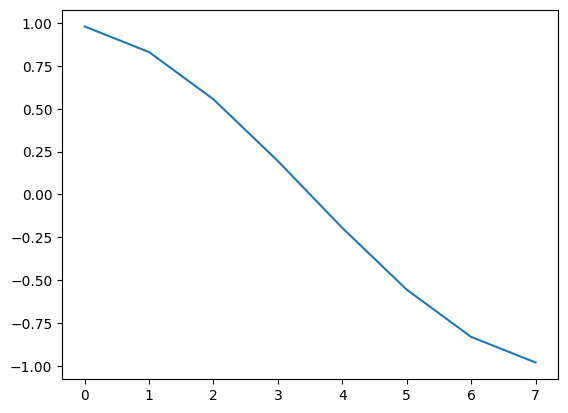

In [37]:
df_log.cos_value.plot()

<Axes: >

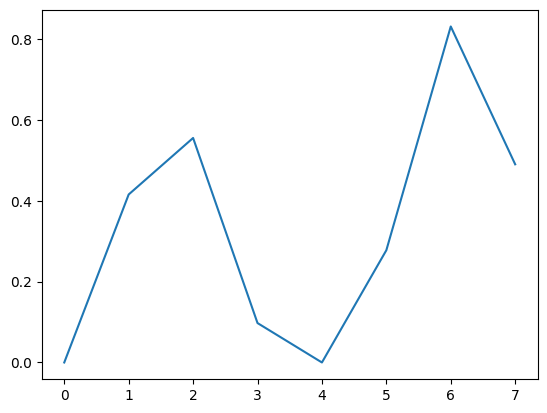

In [40]:
df_log.res.plot()

By modifying your DFT code as shown, you can compute the Discrete Cosine Transform of your signal. The key changes involve:

- Using the DCT-specific angle calculation.

- Replacing the complex exponential with the cosine function.

- Adjusting for scaling factors if necessary.

#### Energy preserving

When working with signal transforms like the Discrete Cosine Transform (DCT) or the Discrete Fourier Transform (DFT), the concept of energy preservation is fundamental. It refers to the property where the total energy of a signal remains the same before and after the transformation. In other words, the sum of the squares of the signal's samples in the time domain is equal to the sum of the squares of its transform coefficients in the frequency domain.

What Does Energy Preservation Mean?
1. Definition of Energy in Signals
In signal processing, the energy of a discrete signal 
𝑥
[
𝑛
]
x[n] is defined as:

𝐸
time
=
∑
𝑛
=
0
𝑁
−
1
∣
𝑥
[
𝑛
]
∣
2
E 
time
​
 = 
n=0
∑
N−1
​
 ∣x[n]∣ 
2
 
𝐸
time
E 
time
​
 : Total energy of the signal in the time domain.
𝑥
[
𝑛
]
x[n]: The signal sample at index 
𝑛
n.
𝑁
N: The total number of samples.
Similarly, the energy in the frequency domain, after applying a transform like the DCT, is:

𝐸
freq
=
∑
𝑘
=
0
𝑁
−
1
∣
𝑋
[
𝑘
]
∣
2
E 
freq
​
 = 
k=0
∑
N−1
​
 ∣X[k]∣ 
2
 
𝐸
freq
E 
freq
​
 : Total energy of the signal in the frequency domain.
𝑋
[
𝑘
]
X[k]: The transform coefficient at frequency index 
𝑘
k.
2. Energy Preservation Property
A transform is energy-preserving if:

𝐸
time
=
𝐸
freq
E 
time
​
 =E 
freq
​
 
This means that the total energy calculated from the time-domain samples is equal to the total energy calculated from the transform coefficients.

3. Parseval's Theorem
The concept of energy preservation is formalized in Parseval's Theorem, which states that the sum of the squares of a function is equal to the sum of the squares of its transform coefficients. For the DCT, a form of Parseval's Theorem applies, ensuring that:

∑
𝑛
=
0
𝑁
−
1
∣
𝑥
[
𝑛
]
∣
2
=
∑
𝑘
=
0
𝑁
−
1
∣
𝑋
[
𝑘
]
∣
2
n=0
∑
N−1
​
 ∣x[n]∣ 
2
 = 
k=0
∑
N−1
​
 ∣X[k]∣ 
2
 
provided that appropriate scaling factors are used in the transform.



#### visualize orthogonal basis functions

In [41]:
import numpy as np
import matplotlib.pyplot as plt

In [42]:
# Define the interval
T = 1.0  # Period
N = 500  # Number of sample points
t = np.linspace(0, T, N, endpoint=False)


In [43]:
k = 3  # Frequency index for the first basis function
n = 5  # Frequency index for the second basis function

phi_k = np.cos(2 * np.pi * k * t / T)
phi_n = np.cos(2 * np.pi * n * t / T)


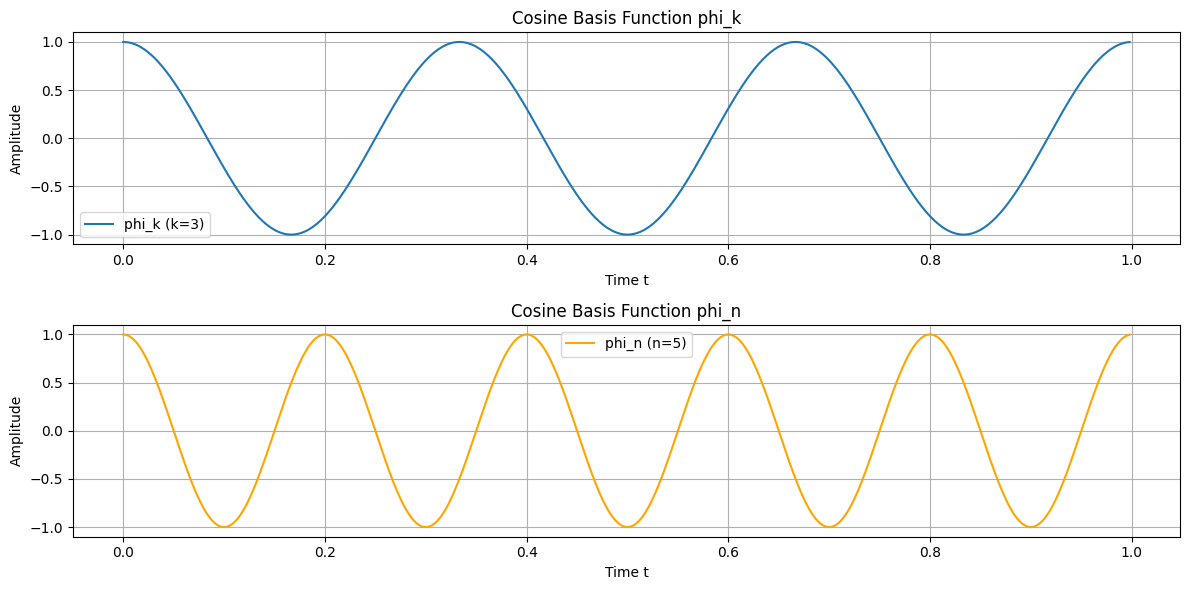

In [44]:
plt.figure(figsize=(12, 6))

# Plot phi_k
plt.subplot(2, 1, 1)
plt.plot(t, phi_k, label=f'phi_k (k={k})')
plt.title('Cosine Basis Function phi_k')
plt.xlabel('Time t')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Plot phi_n
plt.subplot(2, 1, 2)
plt.plot(t, phi_n, label=f'phi_n (n={n})', color='orange')
plt.title('Cosine Basis Function phi_n')
plt.xlabel('Time t')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [45]:
# Compute the inner product (approximate integral using trapezoidal rule)
inner_product = np.trapz(phi_k * phi_n, t)

print(f"Inner product of phi_k and phi_n: {inner_product}")


Inner product of phi_k and phi_n: -0.001997317603132309


In [46]:
# Compute norms
norm_phi_k = np.sqrt(np.trapz(phi_k * phi_k, t))
norm_phi_n = np.sqrt(np.trapz(phi_n * phi_n, t))

# Normalize
phi_k_normalized = phi_k / norm_phi_k
phi_n_normalized = phi_n / norm_phi_n

# Compute inner product of normalized functions
inner_product_normalized = np.trapz(phi_k_normalized * phi_n_normalized, t)

print(f"Inner product of normalized phi_k and phi_n: {inner_product_normalized}")


Inner product of normalized phi_k and phi_n: -0.004010656321615043


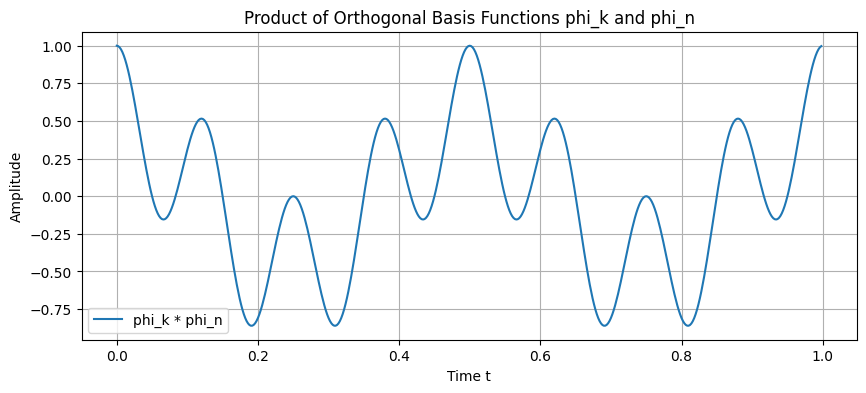

In [47]:
# Plot the product of phi_k and phi_n
product = phi_k * phi_n

plt.figure(figsize=(10, 4))
plt.plot(t, product, label='phi_k * phi_n')
plt.title('Product of Orthogonal Basis Functions phi_k and phi_n')
plt.xlabel('Time t')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


If the area under the curve of the product is zero (or close to zero), it indicates orthogonality.

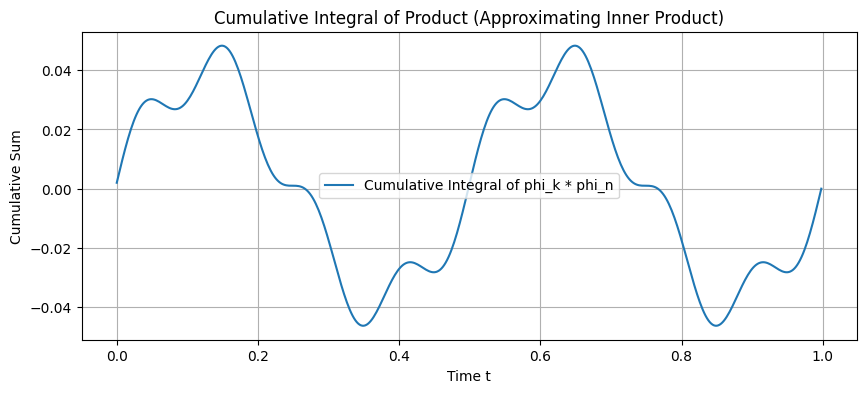

In [48]:
# Cumulative integral of the product
cumulative_integral = np.cumsum(product) * (t[1] - t[0])

plt.figure(figsize=(10, 4))
plt.plot(t, cumulative_integral, label='Cumulative Integral of phi_k * phi_n')
plt.title('Cumulative Integral of Product (Approximating Inner Product)')
plt.xlabel('Time t')
plt.ylabel('Cumulative Sum')
plt.legend()
plt.grid(True)
plt.show()


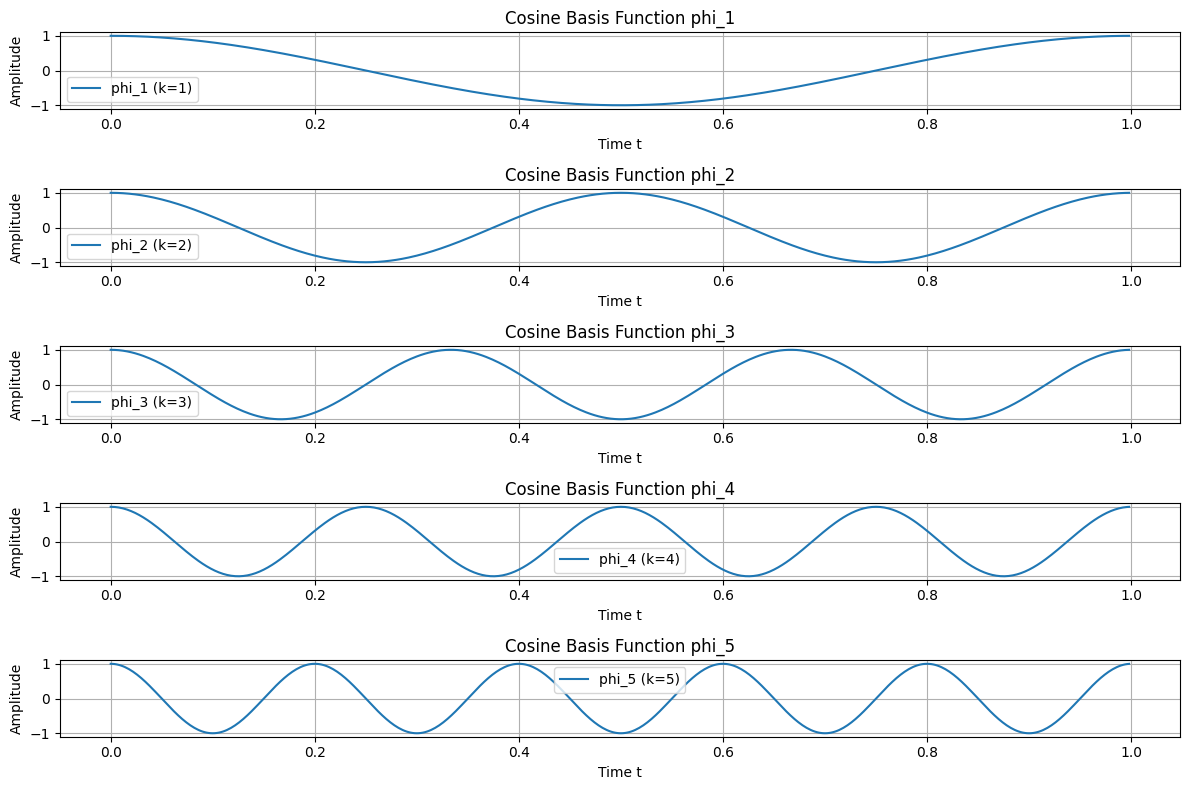

In [49]:
frequency_indices = [1, 2, 3, 4, 5]  # Different frequency indices
basis_functions = []

plt.figure(figsize=(12, 8))

for idx, k in enumerate(frequency_indices):
    phi_k = np.cos(2 * np.pi * k * t / T)
    basis_functions.append(phi_k)
    plt.subplot(len(frequency_indices), 1, idx + 1)
    plt.plot(t, phi_k, label=f'phi_{k} (k={k})')
    plt.title(f'Cosine Basis Function phi_{k}')
    plt.xlabel('Time t')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [50]:
# Compute the inner product matrix
num_functions = len(basis_functions)
inner_product_matrix = np.zeros((num_functions, num_functions))

for i in range(num_functions):
    for j in range(num_functions):
        inner_product_matrix[i, j] = np.trapz(basis_functions[i] * basis_functions[j], t)

# Print the inner product matrix
print("Inner Product Matrix:")
print(inner_product_matrix)


Inner Product Matrix:
[[ 0.49800016 -0.00199961 -0.00199921 -0.00199866 -0.00199795]
 [-0.00199961  0.49800063 -0.00199897 -0.00199842 -0.00199771]
 [-0.00199921 -0.00199897  0.49800142 -0.00199803 -0.00199732]
 [-0.00199866 -0.00199842 -0.00199803  0.49800252 -0.00199677]
 [-0.00199795 -0.00199771 -0.00199732 -0.00199677  0.49800394]]


<Axes: >

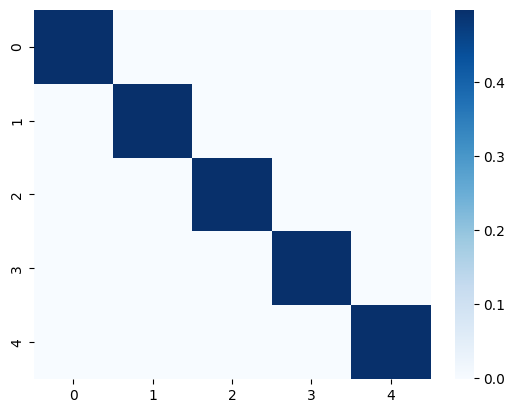

In [52]:
import seaborn as sns
sns.heatmap(inner_product_matrix, robust=True, cmap='Blues')

## DCT: basis and signal phase alignment - how dct detects frequency even if sifgnal and basis signal phases don't align 

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct


In [54]:
N = 256  # Number of samples
n = np.arange(N)
k0 = 10  # Frequency index corresponding to the signal's frequency
A = 1.0  # Amplitude
phi = np.pi / 4  # Phase shift (45 degrees)


In [59]:
# DCT frequency indices
k = np.arange(N)

# Generate the signal
x = A * np.cos(np.pi * (n + 0.5) * k0 / N + phi)
x_no_shift=A * np.cos(np.pi * (n + 0.5) * k0 / N)

In [56]:
# Compute the DCT of the signal
X = dct(x, type=2, norm='ortho')


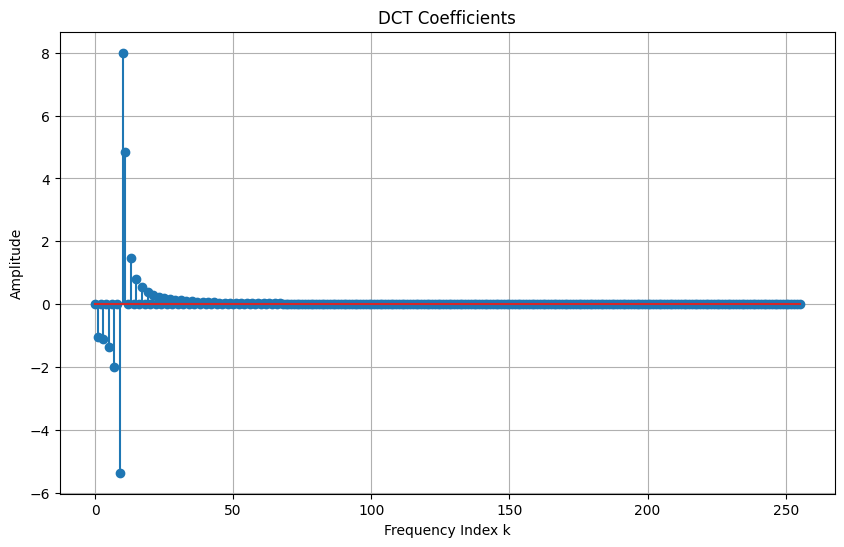

In [58]:
plt.figure(figsize=(10, 6))
plt.stem(k, X)
plt.title('DCT Coefficients')
plt.xlabel('Frequency Index k')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

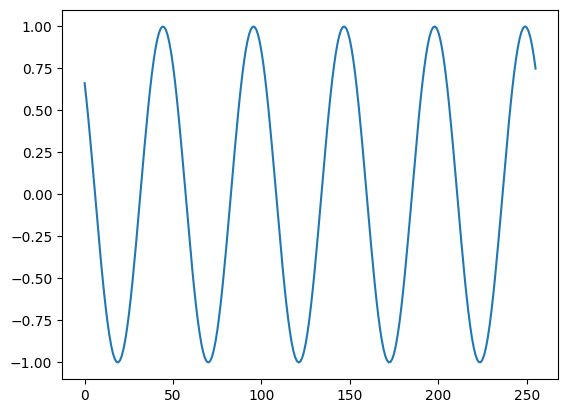

In [60]:
plt.plot(x)

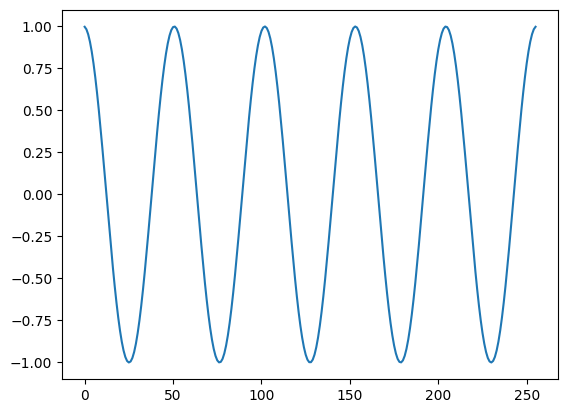

In [61]:
plt.plot(x_no_shift)

Energy Spread and Phase Differences in DCT Coefficients
Energy Spread
The energy is not only concentrated at 
𝑘
=
𝑘
0
k=k 
0
​
  but also spreads into adjacent coefficients.

Reason: The phase shift causes the signal not to align perfectly with the cosine basis function at 
𝑘
=
𝑘
0
k=k 
0
​
 .

1. Phase Differences Affect Coefficient Magnitudes
Magnitude Reduction: When the signal's phase differs from the basis function's phase, the magnitude of the corresponding DCT coefficient decreases.
Energy Redistribution: The "missing" energy due to the phase difference appears in other coefficients.
2. DCT Captures Overall Frequency Content
Frequency Detection: The DCT can detect that a frequency component is present because the coefficients at and around 
𝑘
=
𝑘
0
k=k 
0
​
  have significant magnitudes.
Phase Information: While the DCT doesn't provide explicit phase information, the pattern of the coefficients can imply phase differences.
3. Summation of Cosine Basis Functions
The DCT reconstructs the signal using a sum of cosine functions:

𝑥
[
𝑛
]
=
∑
𝑘
=
0
𝑁
−
1
𝑋
[
𝑘
]
⋅
cos
⁡
(
𝜋
𝑁
(
𝑛
+
1
2
)
𝑘
)
x[n]= 
k=0
∑
N−1
​
 X[k]⋅cos( 
N
π
​
 (n+ 
2
1
​
 )k)
Adjusting Phases: The combination of multiple cosine functions with different frequencies can approximate phase shifts in the original signal.






